## Post Processing
GTやFuel Demandの部分についての汎用化を行うために"GT_heatrate"と"Add_Fuel_Demand"について条件を振ったデータセットの再構築を行う。  
新しいデータセットを作るにあたっては以下2通りを検討した。
- Case1 元データセットをすべての組み合わせ　× 指定した"GT_heatrate"と"Add_Fuel_Demand"のすべての組み合わせ
- Case2 元データセットからランダム抽出 ＋ "GT_heatrate"と"Add_Fuel_Demand"をランダム抽出  
のちのBest Parameter算出の検証において、Case2ではうまくピークが得られなかったため、Case1を採用することになった。

## Post Processing (As per Google Translate)
Reconstruct the dataset with conditions for "GT_heatrate" and "Add_Fuel_Demand" in order to generalize the GT and Fuel Demand parts.
In creating a new data set, we considered the following two methods.
- Case1 All combinations of the original data set × All combinations of the specified "GT_heatrate" and "Add_Fuel_Demand"
- Case2 Random sampling from the original dataset + Random sampling of "GT_heatrate" and "Add_Fuel_Demand"

In the later verification of the Best Parameter calculation, Case 2 did not give a good peak, so Case 1 was adopted.

### ライブラリー、モデル、データセットの読み込み (Loading libraries, models and datasets)

In [1]:
import sys, os, math
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import *
import gc
from tqdm import tqdm #時間表示用(Time indication)

pd.set_option('display.max_columns', 200) #df表示数増加(df means number increase)

import tensorflow as tf
print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2.4.1
1 Physical GPUs, 1 Logical GPUs


In [2]:
# # # データセットの読み込み(Data set loading)
# path = '../../LngGeneralModel_CPW-master1/dataset_preprocessed_11.pkl'
# df_raw = pd.read_pickle(path)
# df_raw.reset_index(inplace=True, drop=True) 
# print("df_raw.shape:", df_raw.shape)

# Count File Numbers
data_dir = '../../LngGeneralModel_CPW_master/output/preprocessed'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("file_num:",file_num)
print(data_filelist)

# Read Data and Integrate into 1 Data Frame
df_raw = pd.DataFrame()
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    print(file_dir)
    df_tmp = pd.read_pickle(file_dir)
    df_raw = pd.concat([df_raw, df_tmp])
df_raw.reset_index(drop=True, inplace=True)
print("df_raw.shape:", df_raw.shape)

df_raw.describe()

file_num: 12
['dataset_preprocessed_0.pkl', 'dataset_preprocessed_1.pkl', 'dataset_preprocessed_10.pkl', 'dataset_preprocessed_11.pkl', 'dataset_preprocessed_2.pkl', 'dataset_preprocessed_3.pkl', 'dataset_preprocessed_4.pkl', 'dataset_preprocessed_5.pkl', 'dataset_preprocessed_6.pkl', 'dataset_preprocessed_7.pkl', 'dataset_preprocessed_8.pkl', 'dataset_preprocessed_9.pkl']
../../LngGeneralModel_CPW_master/output/preprocessed/dataset_preprocessed_0.pkl
../../LngGeneralModel_CPW_master/output/preprocessed/dataset_preprocessed_1.pkl
../../LngGeneralModel_CPW_master/output/preprocessed/dataset_preprocessed_10.pkl
../../LngGeneralModel_CPW_master/output/preprocessed/dataset_preprocessed_11.pkl
../../LngGeneralModel_CPW_master/output/preprocessed/dataset_preprocessed_2.pkl
../../LngGeneralModel_CPW_master/output/preprocessed/dataset_preprocessed_3.pkl
../../LngGeneralModel_CPW_master/output/preprocessed/dataset_preprocessed_4.pkl
../../LngGeneralModel_CPW_master/output/preprocessed/dataset_p

,FEED_N2,FEED_C1,FEED_C2,FEED_C3,FEED_iC4,FEED_nC4,MR_N2,MR_C1,MR_C2,MR_C3,MR_C4,AmbTemp,CW_Temp,Feed_Press,Feed_Temp,MCHE_WB_Out_Temp,MCHE_CB_Out_Temp,LPMR_Suc_Press,HPMR_Dis_Press,Cooler_Out_Temp_AFC,Cooler_Out_Temp_CW,MCHE_WB_DT,MR_HT_Eff,Cond_Out_Temp_AFC,Sub_Out_Temp_AFC,Cond_Out_Temp_CW,Sub_Out_Temp_CW,pre_MR_VL,MCHE_IN_T,MCHE_IN_C_T,MCHE_MID_C_T,MCHE_OUT_C_T,MCHE_OUT_P,MCHE_SEP_T,LPMR_Dis_Press,MPMR_Suc_Press,MPMR_Dis_Press,HPMR_Suc_Press,LPMR_Suc_Temp,LPMR_Dis_Temp,MPMR_Suc_Temp,MPMR_Dis_Temp,HPMR_Suc_Temp,HPMR_Dis_Temp,WB_UA,CB_UA,C3_GT_Power,LPMR_GT_Power,MPMR_GT_Power,HPMR_GT_Power,FEED_MassFlow,FEED_LHV,LNG_Rundown,LNG_Dens,EFG,EFG_LHV,LNG_Prod,LNG_LHV,COND_Prod,COND_LHV,SpecPower,ThermalEff,FFF_Flow,GT_Eff,MR_FLOW,MR_GASFLOW,MR_SUCT_VL,LMR_FLOW,LMR_GASFLOW,HMR_FLOW,HMR_VFLOW,C3_FLOW,WB_LMTD,WB_Min,CB_LMTD,CB_Min,UA_Rate,SpecPower_DSLNG,ThermalEff_DSLNG,FFF_Flow_DSLNG,BOG,liquefaction_feed_heat,LNG_heat,EFG_heat,BOG_heat,Cond_heat,comp_power_total,EFG_1,EFG_LHV_1,LNG_Prod_1,LNG_LHV_1,EFG_2,EFG_LHV_2,LNG_Prod_2,LNG_LHV_2,EFG_3,EFG_LHV_3,LNG_Prod_3,LNG_LHV_3,EFG_Drum_3,EFG_Drum_LHV_3,LNG_heat_1,EFG_heat_1,BOG_heat_1,FFF_Flow_1,FFF_Flow_act_1,ThermalEff_1,SpecPower_1,LNG_heat_2,EFG_heat_2,BOG_heat_2,FFF_Flow_2,FFF_Flow_act_2,ThermalEff_2,SpecPower_2,LNG_heat_3,EFG_heat_3,BOG_heat_3,FFF_Flow_3,FFF_Flow_act_3,ThermalEff_3,SpecPower_3
count,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,1.377720e+05,1.377720e+05,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,1.377720e+05,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.0,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,1.377720e+05,1.377720e+05,137772.000000,137772.000000,137772.000000,1.377720e+05,137772.000000,1.377720e+05,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,1.377720e+05,1.377720e+05,1.377720e+05,1.377720e+05,137772.0,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,137772.000000,1.377720e+05,1.377720e+05,1.377720e+05,137772.000000,137772.000000,137772.000000,137772.000000,1.377720e+05,1.377720e+05,1.377720e+05,137772.000000,137772.000000,137772.000000,137772.000000,1.377720e+05,1.377720e+05,1.377720e+05,137772.000000,137772.000000,137772.000000,137772.000000
mean,3.467763,90.054169,3.963739,2.013112,0.167072,0.334145,13.004571,38.133367,35.037003,13.138680,0.686378,25.396804,29.982304,66.601555,22.509374,-132.895340,-152.820589,2.917093,57.852499,35.400931,35.982569,4.077130,41.432889,45.444375,35.442837,39.976262,32.974171,0.376666,-34.232374,-38.310806,-139.036927,-165.722493,45.101555,-34.313577,18.275381,17.775381,32.318874,31.818874,-38.505265,78.529523,35.400931,76.816239,35.400931,78.480845,4.662841e+07,2.219934e+06,52056.494647,74159.646087,25943.270429,24387.043449,645237.836632,46898.769519,6.452378e+05,447.336219,63624.907820,31807.574574,581612.928878,48665.975391,0.0,46898.769519,303.539852,0.907708,12005.777211,0.298230,1.384622e+06,1.172670e+06,0.999986,421469.308188,423099.197120,9.631526e+05,1647.910700,1.944860e+06,5.907705,2.208331,11.069726,9.444528,0.821636,303.539852,0.907708,12005.777211,1677.510821,3.026086e+10,2.830839e+10,1.952467e+09,5.309705e+07,0.0,176546.454612,68

In [3]:
# # Pre-processing: UA Extraction
# df_raw_temp = df_raw.copy()
# df_raw = df_raw[(df_raw['WB_UA'] > 1.5 * 10**7) & (df_raw['WB_UA'] < 6 * 10**7)]
# df_raw = df_raw[(df_raw['CB_UA'] > 0.75 * 10**6) & (df_raw['CB_UA'] < 3 * 10**6)]
# df_raw.reset_index(inplace=True, drop=True) # Indexを振りなおす(Re-roll)

# df_raw.describe()

UA抽出結果(Extraction result) 

データ数(The number of data) 137772 → 104608 

WB_UA 最小値(Min value):  1.00e+07 → 1.50e+07
WB_UA 最頻値(Mode):  3.35e+07 → 3.35e+07
WB_UA 中央値(Median):  3.85e+07 → 3.70e+07
WB_UA 平均値(Mean):  4.66e+07 → 4.21e+07
WB_UA 最大値(Max value):  1.50e+08 → 1.00e+08 

CB_UA 最小値(Min value):  1.15e+05 → 7.50e+05
CB_UA 最頻値(Mode):  1.39e+06 → 1.39e+06
CB_UA 中央値(Median):  1.69e+06 → 1.75e+06
CB_UA 平均値(Mean):  2.22e+06 → 2.03e+06
CB_UA 最大値(Max value):  1.00e+07 → 5.00e+06 



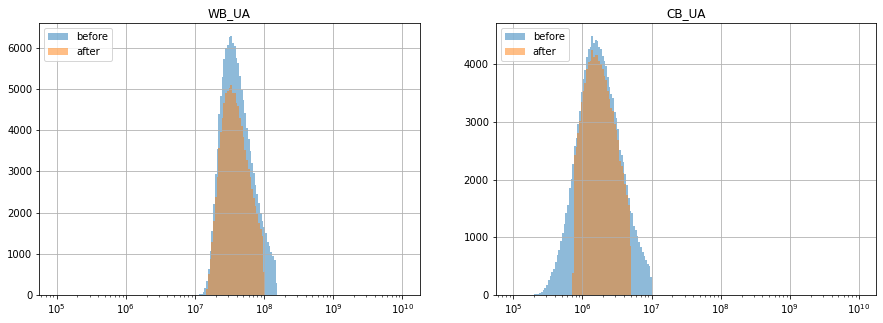

In [4]:
# Pre-processing_2 UA Extraction
UA_list = ['WB_UA', 'CB_UA']

df_raw_temp = df_raw.copy()

# UAの外れ値を除外(Exclude outliers)___ Case-C
df_raw = df_raw[(df_raw['WB_UA'] > 1.5 * 10**7) & (df_raw['WB_UA'] < 10 * 10**7)]
df_raw = df_raw[(df_raw['CB_UA'] > 0.75 * 10**6) & (df_raw['CB_UA'] < 5 * 10**6)]

df_raw.reset_index(inplace=True, drop=True) # Indexを振りなおす(Re-roll)

print("UA抽出結果(Extraction result)","\n")
print("データ数(The number of data)", df_raw_temp.shape[0], "→", df_raw.shape[0],"\n")

# 可視化(Visualization)
num_row = math.ceil(len(df_raw.loc[:, UA_list].columns) / 2)

plt.figure(figsize=(15, 5 * num_row))
i = 0

for tag in df_raw.loc[:, UA_list].columns:
    i += 1
    plt.subplot(num_row, 2, i)
    n_raw, bins_raw, patches_raw = plt.hist(x=df_raw_temp[tag], bins=np.logspace(5, 10, 200), alpha=0.5, label="before")
    n, bins, patches = plt.hist(df_raw[tag], bins=np.logspace(5, 10, 200), alpha=0.5, label="after")
    plt.legend(loc="upper left")
    plt.xscale('log')
    plt.grid()
    plt.title(label=tag)
    mode_index_raw = n_raw.argmax()
    mode_index = n.argmax()
    print(tag, '最小値(Min value): ', f"{df_raw_temp[tag].min():.2e}", "→", f"{df_raw[tag].min():.2e}")
    print(tag, '最頻値(Mode): ', f"{(bins_raw[mode_index_raw] + bins[mode_index_raw+1])/2:.2e}", "→", f"{(bins[mode_index] + bins[mode_index+1])/2:.2e}")
    print(tag, '中央値(Median): ', f"{df_raw_temp[tag].median():.2e}", "→", f"{df_raw[tag].median():.2e}")
    print(tag, '平均値(Mean): ', f"{df_raw_temp[tag].mean():.2e}", "→", f"{df_raw[tag].mean():.2e}")
    print(tag, '最大値(Max value): ', f"{df_raw_temp[tag].max():.2e}", "→", f"{df_raw[tag].max():.2e}","\n")


plt.show()

In [5]:
# Columnの抽出用 - dfには不要な列も含むため、以下に指定したTag (list_total) のみを最終的なOutputのdfの列として抽出する。
# For column extraction 
# --Since df includes unnecessary columns, only the Tag (list_total) specified below is extracted as the final Output df column.

# explanatory variable - given
list_u = [
    'FEED_N2', 'FEED_C1', 'FEED_C2', 'FEED_C3',#     'FEED_iC4',#     'FEED_nC4',    # 'FEED_C5+',
    'AmbTemp', 'Cond_Out_Temp_AFC',    # 'MCHE_IN_T',
    'WB_UA', 'CB_UA', 'MR_HT_Eff', 'Feed_Press', 'Feed_Temp'
]

# explanatory variable - given (additional)
list_u2 = ["GT_heatrate", "Add_Fuel_Demand"]

# explanatory variable - search
list_v = [
    'HPMR_Dis_Press', 'LPMR_Suc_Press', 'MCHE_WB_DT',
    'MR_N2', 'MR_C1', 'MR_C2', 'MR_C3',#     'MR_C4'
]

list_x = list_u + list_u2 + list_v

# target variable
list_y = [
    "MCHE_CB_Out_Temp",
    "FFF_Flow_GenGT_1", "FFF_Flow_act_GenGT_1", "ThermalEff_GenGT_1", "SpecPower_GenGT_1",
    "FFF_Flow_GenGT_2", "FFF_Flow_act_GenGT_2", "ThermalEff_GenGT_2", "SpecPower_GenGT_2",
    "FFF_Flow_GenGT_3", "FFF_Flow_act_GenGT_3", "ThermalEff_GenGT_3", "SpecPower_GenGT_3",   
]

# other variable
list_o = ["FEED_MassFlow"]

list_total = list_x + list_y + list_o

## データセットの構築(Dataset construction)

In [6]:
# Case 1 全件使用(Full use)
cols = df_raw.columns.values.tolist() + ["GT_heatrate","Add_Fuel_Demand"]

heat_rate_list = [9000, 10000, 11000, 12000]
fuel_demand_list = [0, 5*1000, 10*1000, 20*1000]

file_num = 50

for j in tqdm(range(0, file_num)):
    row_num = df_raw.shape[0]//file_num
    df_temp = df_raw[j*row_num:(j+1)*row_num].copy()
    df = pd.DataFrame(index=[], columns=[])
 
    for _, item in df_temp.iterrows():
        for GT_heatrate in heat_rate_list:
            for Additional_Fuel_Demand in fuel_demand_list:
                row = pd.DataFrame(np.concatenate([item.values, [GT_heatrate, Additional_Fuel_Demand]])).T
                df = pd.concat([df, row], axis=0)

    df.index = range(df_temp.shape[0] * len(heat_rate_list)*len(fuel_demand_list))
    df.columns = cols            

    for i in range(1,4): #Rundownのそれぞれのパターン(1_Direct, 2_LNG_HT, 3_EFG)毎に計算 (Calculated for each Rundown pattern (1_Direct, 2_LNG_HT, 3_EFG))
        comp_heat = df["comp_power_total"] * df["GT_heatrate"] #kJ/h, CompressorへのFuel必要熱量 (Fuel required heat for Compressor)
        LNG_heat = df["LNG_Prod_{}".format(i)] * df["LNG_LHV_{}".format(i)]
        EFG_heat = df["EFG_{}".format(i)] * df["EFG_LHV_{}".format(i)]
        BOG_heat = df["BOG"] * df["EFG_LHV_{}".format(i)]
        Additional_heat = df["Add_Fuel_Demand"] * df["EFG_LHV_{}".format(i)]

        # FFF計算 (FFF calculation)
        FFF_heat = comp_heat + Additional_heat - EFG_heat - BOG_heat

        # EFGが過多で、FFFが負となる場合はEFGが一部Flaringしているとみなす
        # If there is too much EFG and FFF is negative, it is considered that EFG is partially flaring.
        FFF_heat_act = FFF_heat.copy()
        FFF_heat_act[FFF_heat_act<= 0] = 0

        # FFF量をdfに追加 (Added FFF amount to df)
        df["FFF_Flow_GenGT_{}".format(i)] = FFF_heat / df["FEED_LHV"]
        df["FFF_Flow_act_GenGT_{}".format(i)] = FFF_heat_act / df["FEED_LHV"]

        # Thermal Efficiencyをdfに追加 (Added Thermal Efficiency to df)
        ThermalEff = (LNG_heat + df["Cond_heat"] - BOG_heat) / (FFF_heat_act + df["liquefaction_feed_heat"])
        df["ThermalEff_GenGT_{}".format(i)] = ThermalEff

        # Specific Powerをdfに追加 (Added Specific Power to df)
        SpecPower = df["comp_power_total"] / df["LNG_Prod_{}".format(i)] * 1000
        df["SpecPower_GenGT_{}".format(i)] = SpecPower   

    df = df[list_total]

    print(j, df.shape)
#     print(df)
    df.to_csv('../../LngGeneralModel_CPW_master/output/postprocessed_CaseC/dataset_postprocessed_{}.csv'.format(j))
    del df
    gc.collect()

  0%|                                                                                                                                                                                                              | 0/50 [00:00<?, ?it/s]

0 (33472, 34)


  2%|███▉                                                                                                                                                                                               | 1/50 [02:09<1:46:03, 129.86s/it]

1 (33472, 34)


  4%|███████▊                                                                                                                                                                                           | 2/50 [05:05<2:05:32, 156.92s/it]

2 (33472, 34)


  6%|███████████▋                                                                                                                                                                                       | 3/50 [08:11<2:13:23, 170.28s/it]

3 (33472, 34)


  8%|███████████████▌                                                                                                                                                                                   | 4/50 [11:13<2:14:07, 174.94s/it]

4 (33472, 34)


 10%|███████████████████▌                                                                                                                                                                               | 5/50 [14:19<2:14:05, 178.78s/it]

5 (33472, 34)


 12%|███████████████████████▍                                                                                                                                                                           | 6/50 [17:26<2:13:10, 181.61s/it]

6 (33472, 34)


 14%|███████████████████████████▎                                                                                                                                                                       | 7/50 [20:26<2:09:46, 181.07s/it]

7 (33472, 34)


 16%|███████████████████████████████▏                                                                                                                                                                   | 8/50 [23:31<2:07:35, 182.28s/it]

8 (33472, 34)


 18%|███████████████████████████████████                                                                                                                                                                | 9/50 [26:32<2:04:11, 181.74s/it]

9 (33472, 34)


 20%|██████████████████████████████████████▊                                                                                                                                                           | 10/50 [29:33<2:01:11, 181.80s/it]

10 (33472, 34)


 22%|██████████████████████████████████████████▋                                                                                                                                                       | 11/50 [32:36<1:58:13, 181.88s/it]

11 (33472, 34)


 24%|██████████████████████████████████████████████▌                                                                                                                                                   | 12/50 [35:35<1:54:45, 181.19s/it]

12 (33472, 34)


 26%|██████████████████████████████████████████████████▍                                                                                                                                               | 13/50 [38:39<1:52:11, 181.94s/it]

13 (33472, 34)


 28%|██████████████████████████████████████████████████████▎                                                                                                                                           | 14/50 [41:38<1:48:35, 180.97s/it]

14 (33472, 34)


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 15/50 [44:40<1:45:52, 181.49s/it]

15 (33472, 34)


 32%|██████████████████████████████████████████████████████████████                                                                                                                                    | 16/50 [47:41<1:42:44, 181.31s/it]

16 (33472, 34)


 34%|█████████████████████████████████████████████████████████████████▉                                                                                                                                | 17/50 [50:41<1:39:25, 180.78s/it]

17 (33472, 34)


 36%|█████████████████████████████████████████████████████████████████████▊                                                                                                                            | 18/50 [53:43<1:36:41, 181.29s/it]

18 (33472, 34)


 38%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 19/50 [56:42<1:33:12, 180.42s/it]

19 (33472, 34)


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 20/50 [59:45<1:30:39, 181.32s/it]

20 (33472, 34)


 42%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 21/50 [1:02:44<1:27:16, 180.56s/it]

21 (33472, 34)


 44%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 22/50 [1:05:45<1:24:21, 180.78s/it]

22 (33472, 34)


 46%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 23/50 [1:08:47<1:21:31, 181.18s/it]

23 (33472, 34)


 48%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 24/50 [1:11:46<1:18:13, 180.53s/it]

24 (33472, 34)


 50%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 25/50 [1:14:50<1:15:34, 181.37s/it]

25 (33472, 34)


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 26/50 [1:17:48<1:12:10, 180.42s/it]

26 (33472, 34)


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 27/50 [1:20:50<1:09:22, 181.00s/it]

27 (33472, 34)


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 28/50 [1:23:51<1:06:22, 181.02s/it]

28 (33472, 34)


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 29/50 [1:26:51<1:03:15, 180.73s/it]

29 (33472, 34)


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 30/50 [1:29:54<1:00:28, 181.45s/it]

30 (33472, 34)


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 31/50 [1:32:53<57:12, 180.66s/it]

31 (33472, 34)


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 32/50 [1:35:57<54:30, 181.71s/it]

32 (33472, 34)


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 33/50 [1:38:57<51:21, 181.24s/it]

33 (33472, 34)


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 34/50 [1:41:58<48:17, 181.09s/it]

34 (33472, 34)


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 35/50 [1:45:01<45:23, 181.57s/it]

35 (33472, 34)


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 36/50 [1:48:01<42:15, 181.11s/it]

36 (33472, 34)


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 37/50 [1:51:05<39:25, 181.99s/it]

37 (33472, 34)


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 38/50 [1:54:04<36:13, 181.16s/it]

38 (33472, 34)


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 39/50 [1:57:07<33:18, 181.67s/it]

39 (33472, 34)


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 40/50 [2:00:09<30:16, 181.68s/it]

40 (33472, 34)


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 41/50 [2:03:10<27:12, 181.43s/it]

41 (33472, 34)


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 42/50 [2:06:13<24:17, 182.14s/it]

42 (33472, 34)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 43/50 [2:09:12<21:07, 181.08s/it]

43 (33472, 34)


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 44/50 [2:12:17<18:13, 182.19s/it]

44 (33472, 34)


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 45/50 [2:15:19<15:11, 182.27s/it]

45 (33472, 34)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 46/50 [2:18:19<12:06, 181.60s/it]

46 (33472, 34)


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 47/50 [2:21:22<09:05, 181.85s/it]

47 (33472, 34)


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 48/50 [2:24:20<06:01, 180.82s/it]

48 (33472, 34)


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 49/50 [2:27:23<03:01, 181.55s/it]

49 (33472, 34)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [2:30:20<00:00, 180.40s/it]


In [7]:
# 全pickleデータの結合
# データのファイル数をカウント
data_dir = '../../LngGeneralModel_CPW_master/output/postprocessed_CaseC'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("ファイル数:", file_num)

# データを読み込み、1つのDataframeに結合
df_combined = pd.DataFrame()  # 最終的にまとめるDataframe
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    df_tmp = pd.read_csv(file_dir)
    df_combined = pd.concat([df_combined, df_tmp])
df_combined.reset_index(drop=True, inplace=True)  # 行のIndexをリセット
print(df_combined.shape)
print("duplicates:", df_combined.duplicated().sum())  # 重複行がないか確認
df_combined.describe()

df_combined.to_csv('../../LngGeneralModel_CPW_master/output/postprocessed_CaseC/dataset_postprocessed_CaseC.csv')

ファイル数: 50
(1673600, 35)
duplicates: 0
